# Problem 1



In [1]:
# Imports

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import optuna


# Load data
mat_file = loadmat('Datasets/sample_1.mat')


# Plotting Sample 1
## Interactive plot of the complete first sample
Interactive plot. You can zoom in and scroll along both axes. 

In [2]:
%matplotlib notebook

data = mat_file['data'][0]
plt.plot(data)

plt.show()

<IPython.core.display.Javascript object>

## Subplots of the first 10000 data points in sample 1
The first 10000 data points and the ground truth in a series of subplots. The axes are scaled so that we can observe what the spikes look like. The red lines parallel to the x axis mark the spike times of spikes in the data set. This is the ground truth. 

We can already observe that there seems to be an offset between the local maximum of a spike and the spike time. The most intuitive explanation for this is that the data set contains the times when a spike was induced through some trigger. As the system is slow the potential of the neurons rises slower and is detectable in form of a local maximum a few timesteps after the spike was induced. 

We will need to take this into account when detecting the spikes. 

<IPython.core.display.Javascript object>

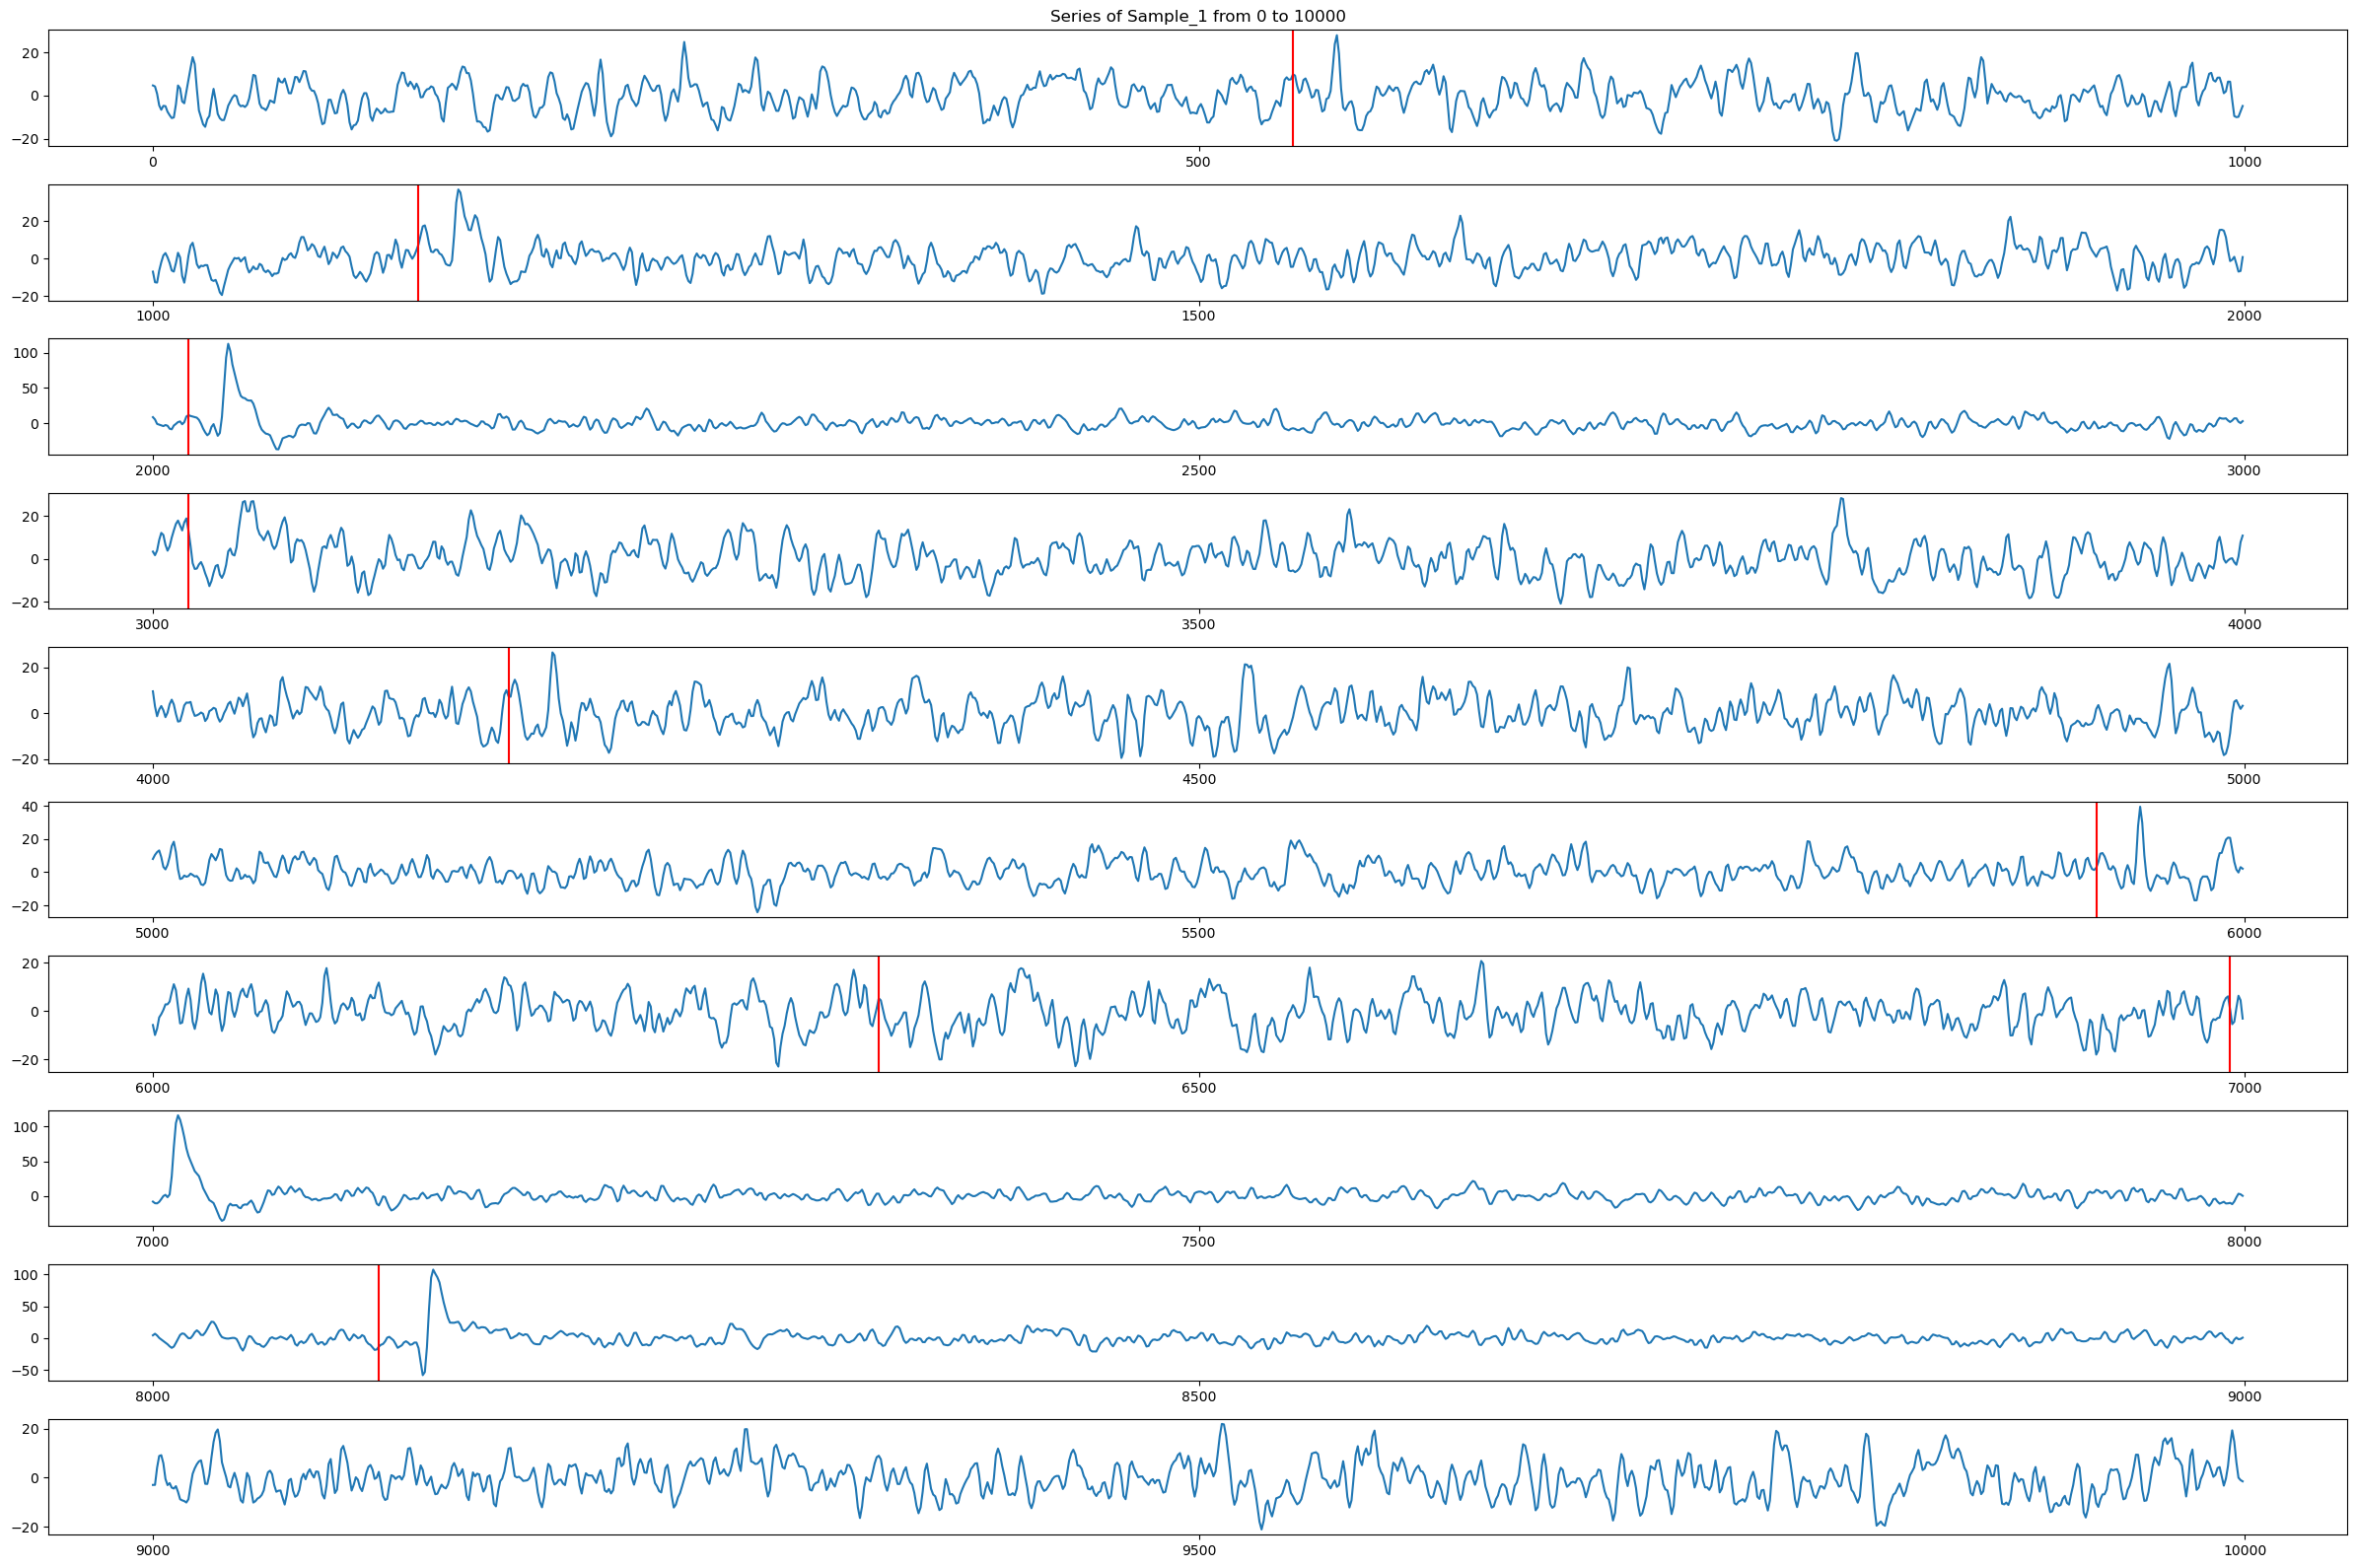

In [3]:
%matplotlib inline
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

# TODO: Add labels

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))


for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE

    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
    

ax[0].set_title("Series of Sample_1 from 0 to 10000")
plt.tight_layout()
# plt.savefig('figures/data_sample_1.pdf')
plt.show() 
    

## Spikes by Classes
The spikes are grouped into different classes according to their properties. Below are plots for each class to get a better understanding of what those properties are. 

In [4]:
def plot_clusters_by_class(class_label):
    data = mat_file['data'][0]
    classes = mat_file['spike_class'][0][0][0]
    spike_times = mat_file['spike_times'][0][0][0]
    
    spikes = spike_times[np.where(classes==class_label)]
    
    fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(24,16))
    
    for i in range(18):

        ax[i//3][i%3].plot(data[spikes[i]-50:spikes[i]+50])
        
    ax[0][1].set_title(f'Spikes of Class {class_label}')
    plt.tight_layout()
    # plt.savefig(f'figures/spike_class_{class_label}_plot.pdf')
    plt.show()

# for debugging
# plot_clusters_by_class(2)

print("Classes in the sample are:")
classes = mat_file['spike_class'][0][0][0]
print(np.unique(classes))

Classes in the sample are:
[0 1 2]


### Class 0

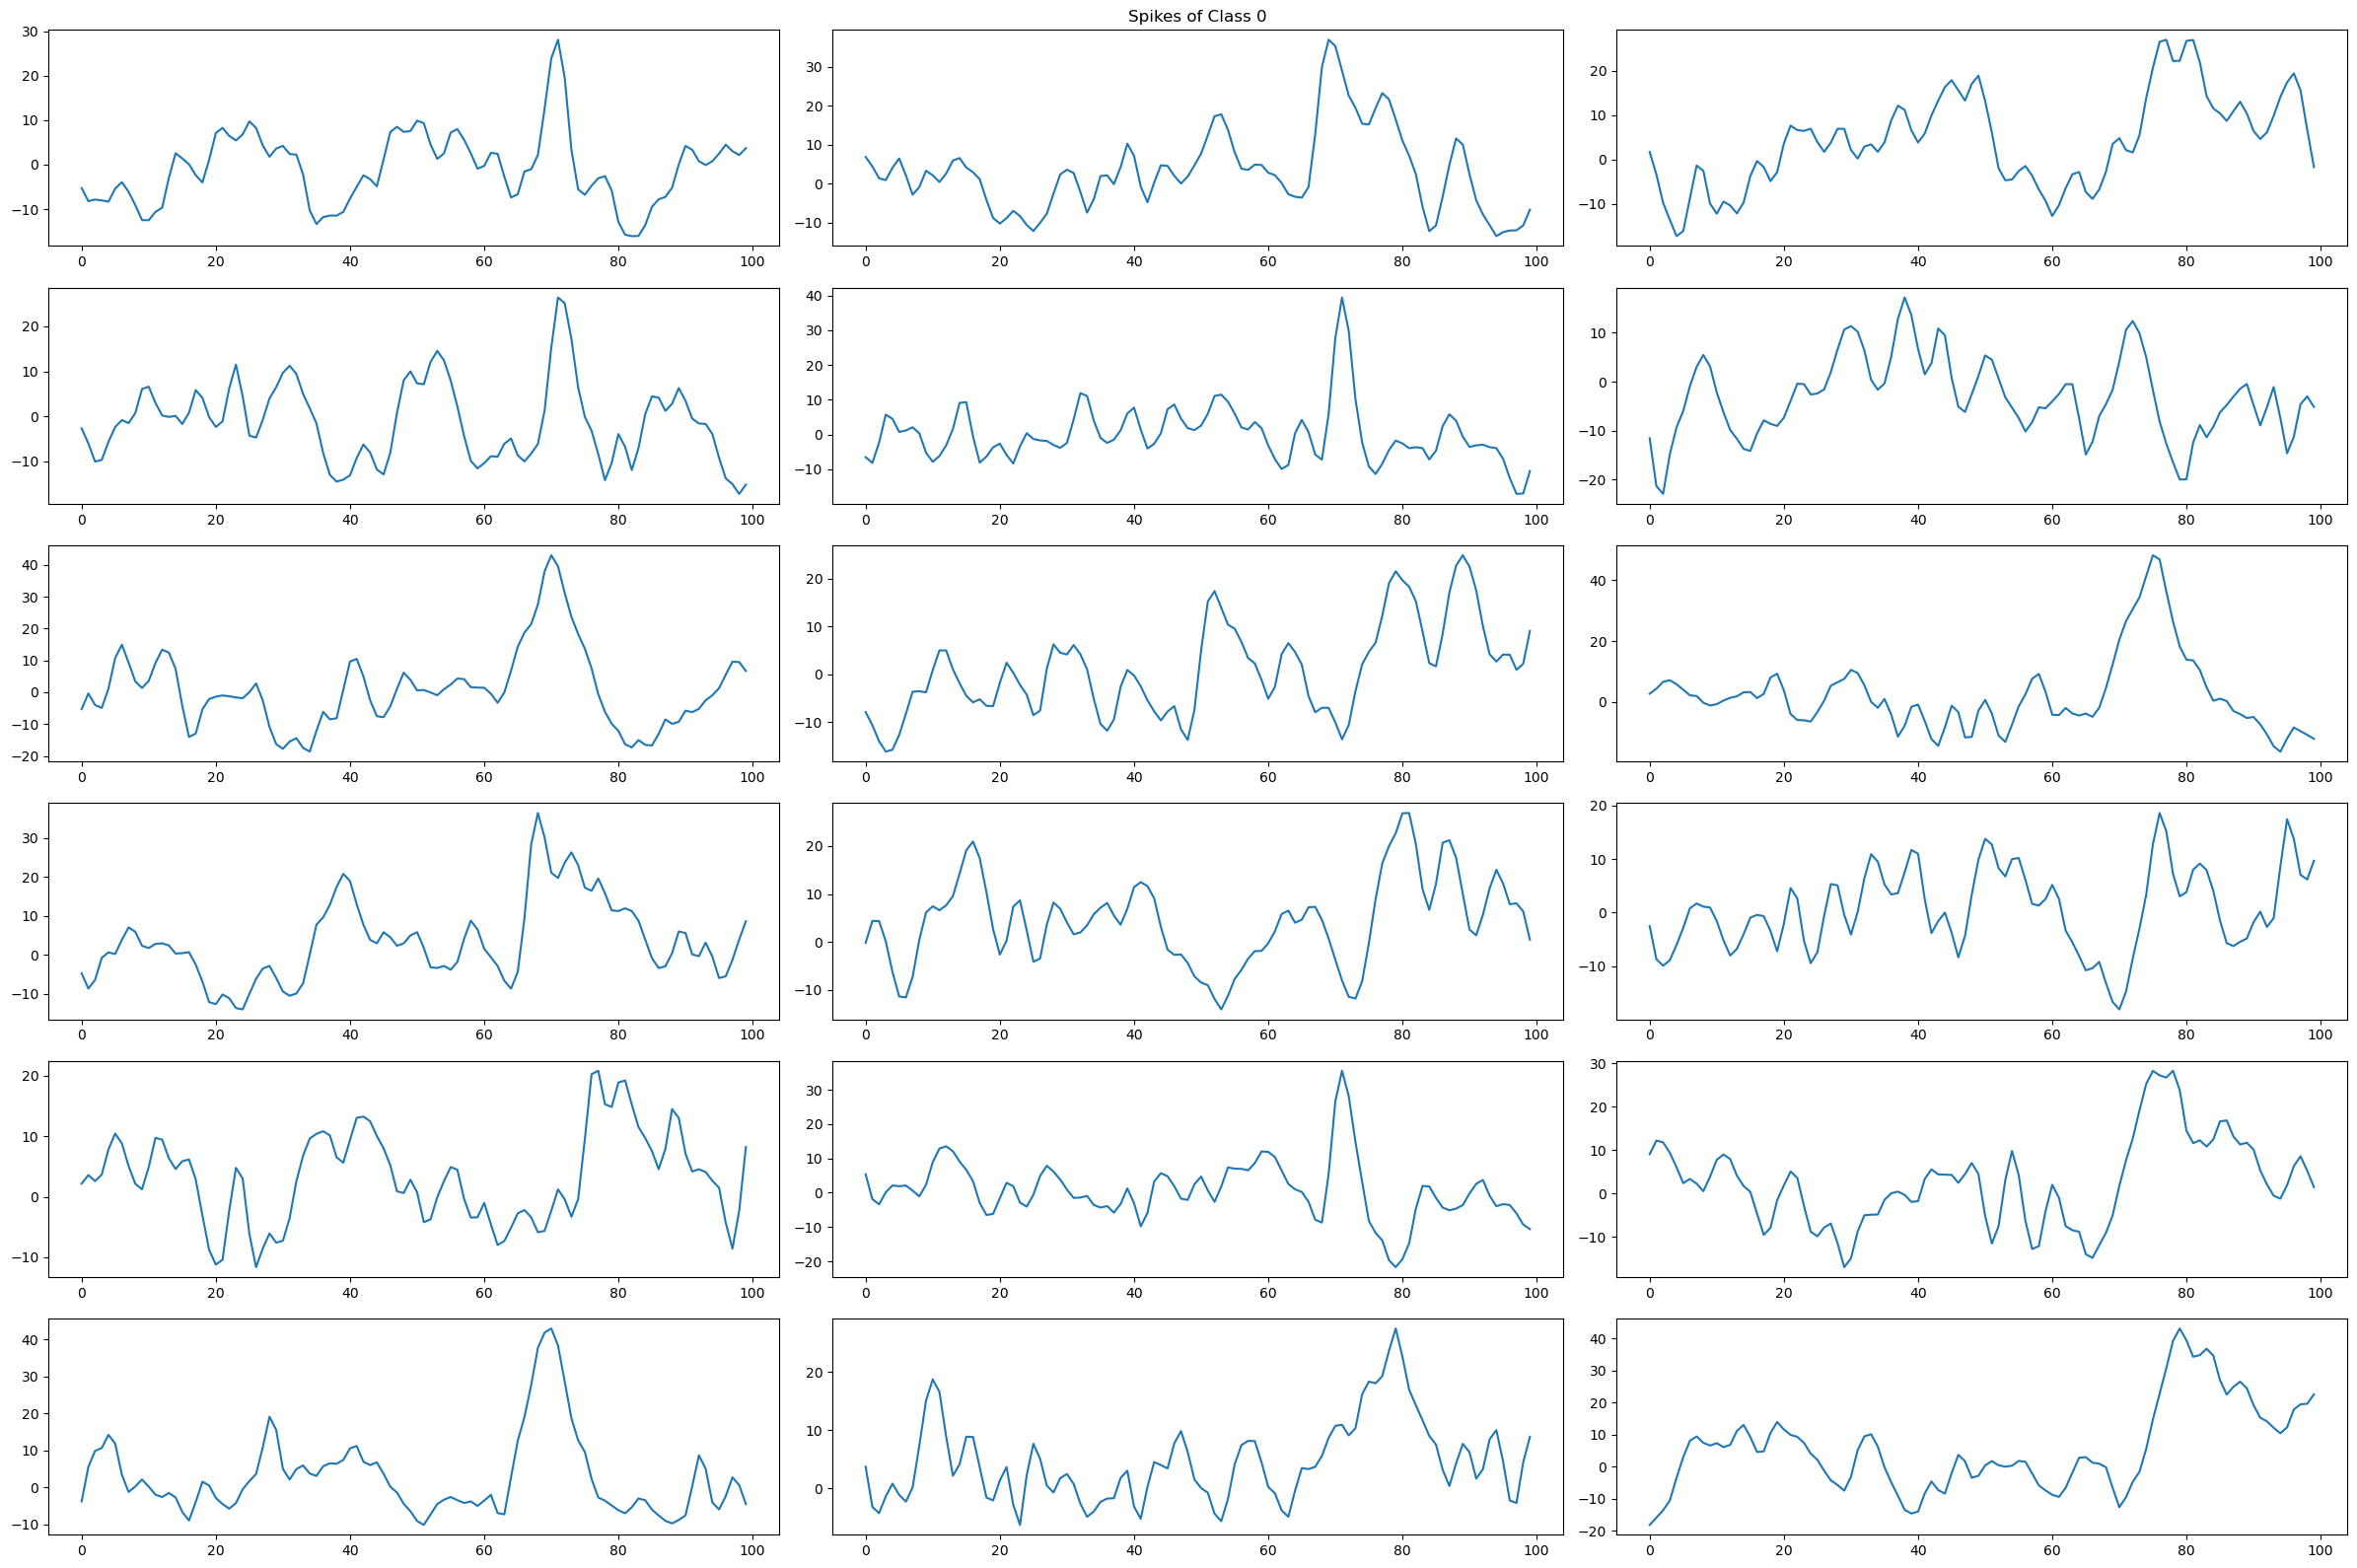

In [5]:
plot_clusters_by_class(0)

### Class 1

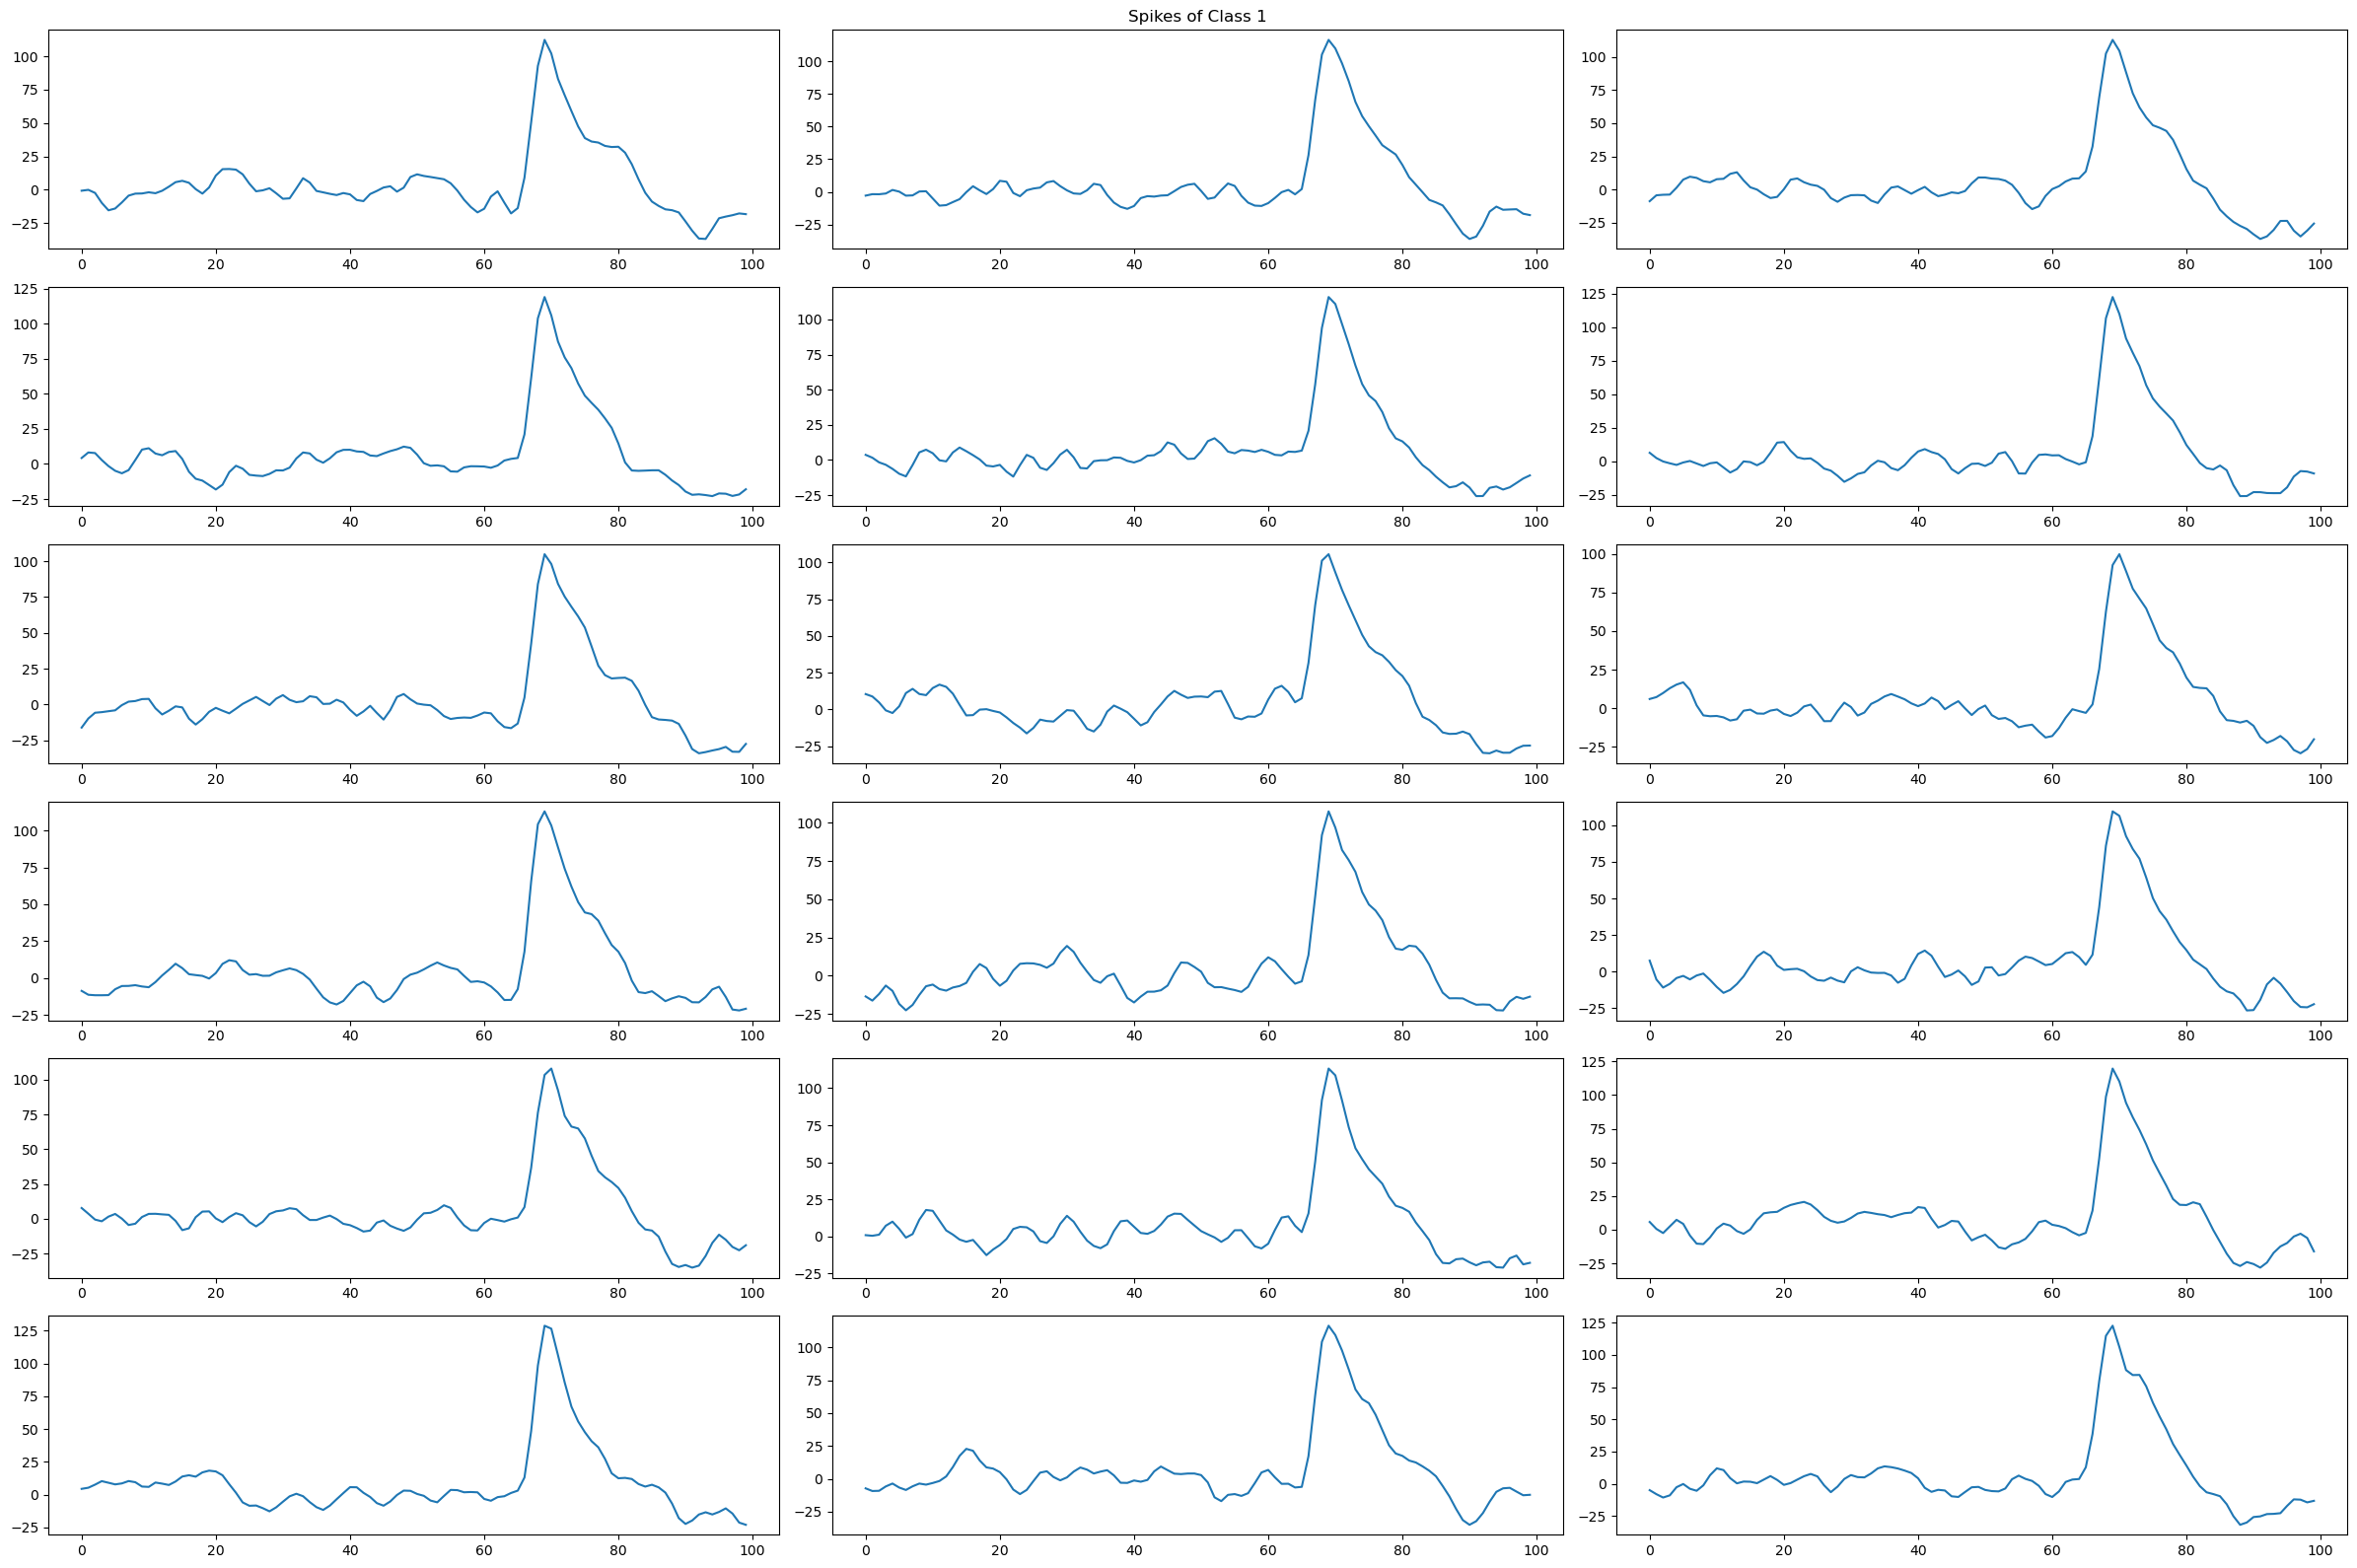

In [6]:
plot_clusters_by_class(1)

### Class 2

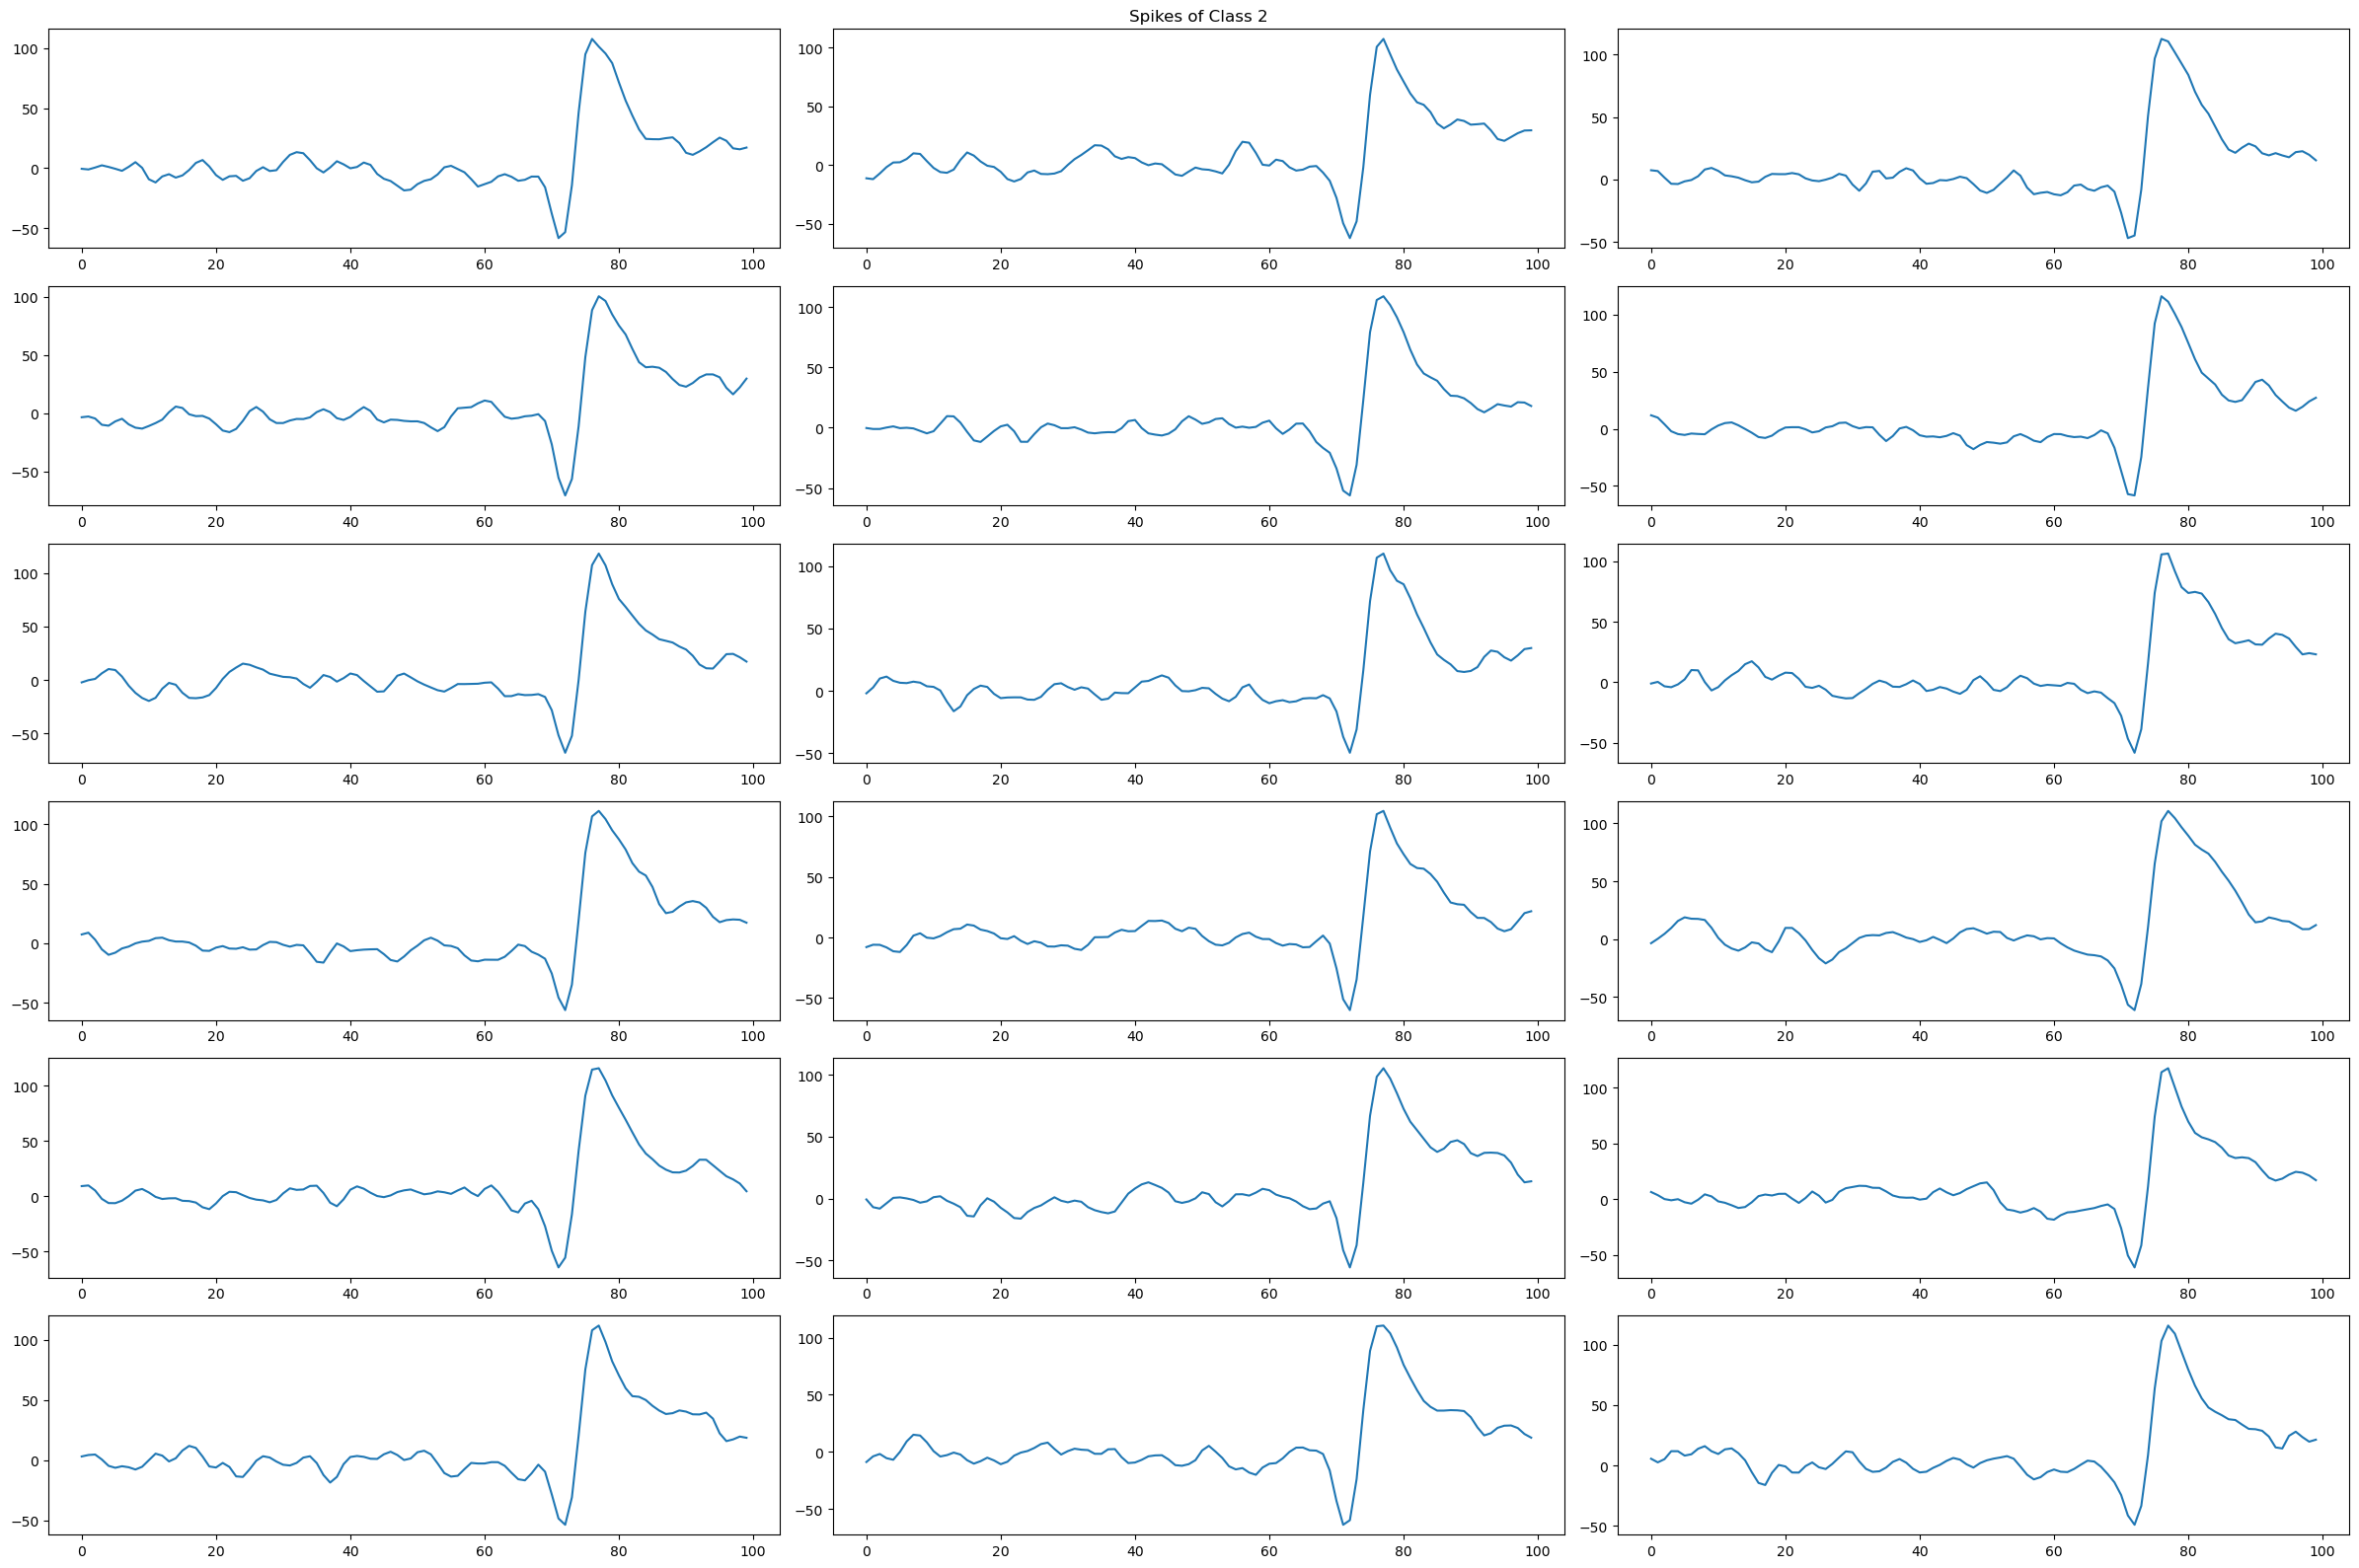

In [7]:
plot_clusters_by_class(2)

# Finding Spikes in the Data
First, we introduce metrics used to evaluate our approach. We will rely on precision and recall in the first step as they account for the number of false positve and false negative predictions that occur. 

If we consider the interval part of our learnable parameters then it might also make sense to introduce the metric "Intersect over Union" As this accounts for the total are of the intervals that match. 


In [10]:

def count_fn_fp(truth, prediction, len_data):
    """"
    Count the number of false positives and false negatives
    Parameters: truth (ground truth) and prediction as numpy arrays
    return: false negatives, false positives, true negative, true positive
    """
    
    matched_spikes = []
    true_positive_spikes = []
    
    for d in truth:
        for p in prediction:
            if d < p < d + 30:
                # true positive found
                matched_spikes.append(d)
                true_positive_spikes.append(p)

                
    false_negative = np.setdiff1d(truth, matched_spikes).shape[0]
    false_positive = np.setdiff1d(prediction, true_positive_spikes).shape[0]
    true_positive = np.array(true_positive_spikes).shape[0]
    true_negative = len_data - truth.shape[0] - false_positive
    
    return false_negative, false_positive, true_negative, true_positive
            

def precision(truth, prediction):
    fn, fp, tp = count_fn_fp(truth, prediction)
    return tp/(tp+fp)

def recall(truth, prediction):
    fn, fp, tp = count_fn_fp(truth, prediction)
    return tp/(tp+fn)

    
def plot_confusion_matrix(truth, prediction, len_data):
    fn, fp, tn, tp = count_fn_fp(truth, prediction, len_data)
    confusion_data = np.array([[tp, fp], [fn, tn]])
    normalized_confusion_data = (confusion_data - np.min(confusion_data)) / (np.max(confusion_data) - np.min(confusion_data))
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(confusion_data, interpolation='nearest', cmap='Blues')
    for (j, i), label in np.ndenumerate(confusion_data):
        ax.text(j, i, label, ha='center', va='center')
    plt.title(f'Confusion Matrix')
    plt.show()
    

def plot_precision_recall():
    # TODO: Only makes sense if we use this metric over a series of attempts to fit the parameters
    pass
    
    
# Debugging

# # params
# interval_param = 25
# threshold_param = 2.7
# 
# # data
# data = mat_file['data'][0]
# spike_times = mat_file['spike_times'][0][0][0]
# 
# 
# # mean and stdv
# mean = np.mean(data, axis=0)
# std_dev = np.std(data, axis=0)
# 
# 
# threshold = mean + threshold_param * std_dev
# 
# detected_spikes = np.where((data > threshold).astype(int) == 1)[0]
# 
# # fn, fp, tp = count_fn_fp(spike_times, detected_spikes, data.shape[0])
# 
# plot_confusion_matrix(spike_times, detected_spikes, data.shape[0])

## Without Z-Score 
In the first step I am setting a threshold based on the mean and the standard deviation of the data. 

In [11]:
# params
interval_param = 25
threshold_param = 2.7

# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)


threshold = mean + threshold_param * std_dev

For every data point I compare two consequitive data points with a threshold. If the first value was below the threshold and the second is above we detect this as a spike. 

In [ ]:
data = mat_file['data'][0]

# for i in range(data.shape[0]-1):
#     if data[i] < threshold and data[i+1] >= threshold:
#         detected_spikes.append(i)

detected_spikes = np.where((data > threshold).astype(int) == 1)[0]

print(detected_spikes)
# detected_spikes = np.array(detected_spikes).reshape(-1,)

# plt.plot(data[0:1000])
# 
# 
# plt.axvline(spike_times[np.where(spike_times<1000)], color='red', label="ground truth")
# 
# # plt.axvline(detected_spikes[np.where(detected_spikes<1000)], color='red', label="ground truth")
# for detected in detected_spikes:
#     if detected < 1000:
#         plt.axvline(detected, color='green', label="detected")
# 
# plt.legend()
# plt.show()


fn, fp, tp, tn = count_fn_fp(data, detected_spikes, data.shape[0])
print(f"There where {tp} spikes detected correctly out of {fn+tp}. [fn = {fn}, tp = {tp}, fp = {fp}]")
precision = precision(data, detected_spikes)
recall = recall(data, detected_spikes)
print(f"Precision: {precision}, Recall: {recall}")

[    566    1145    1146 ... 2879621 2879623 2879624]


Let's create some plots of what we detected. We will mark the detected spikes with a green line and the groundtruth with red as before. 

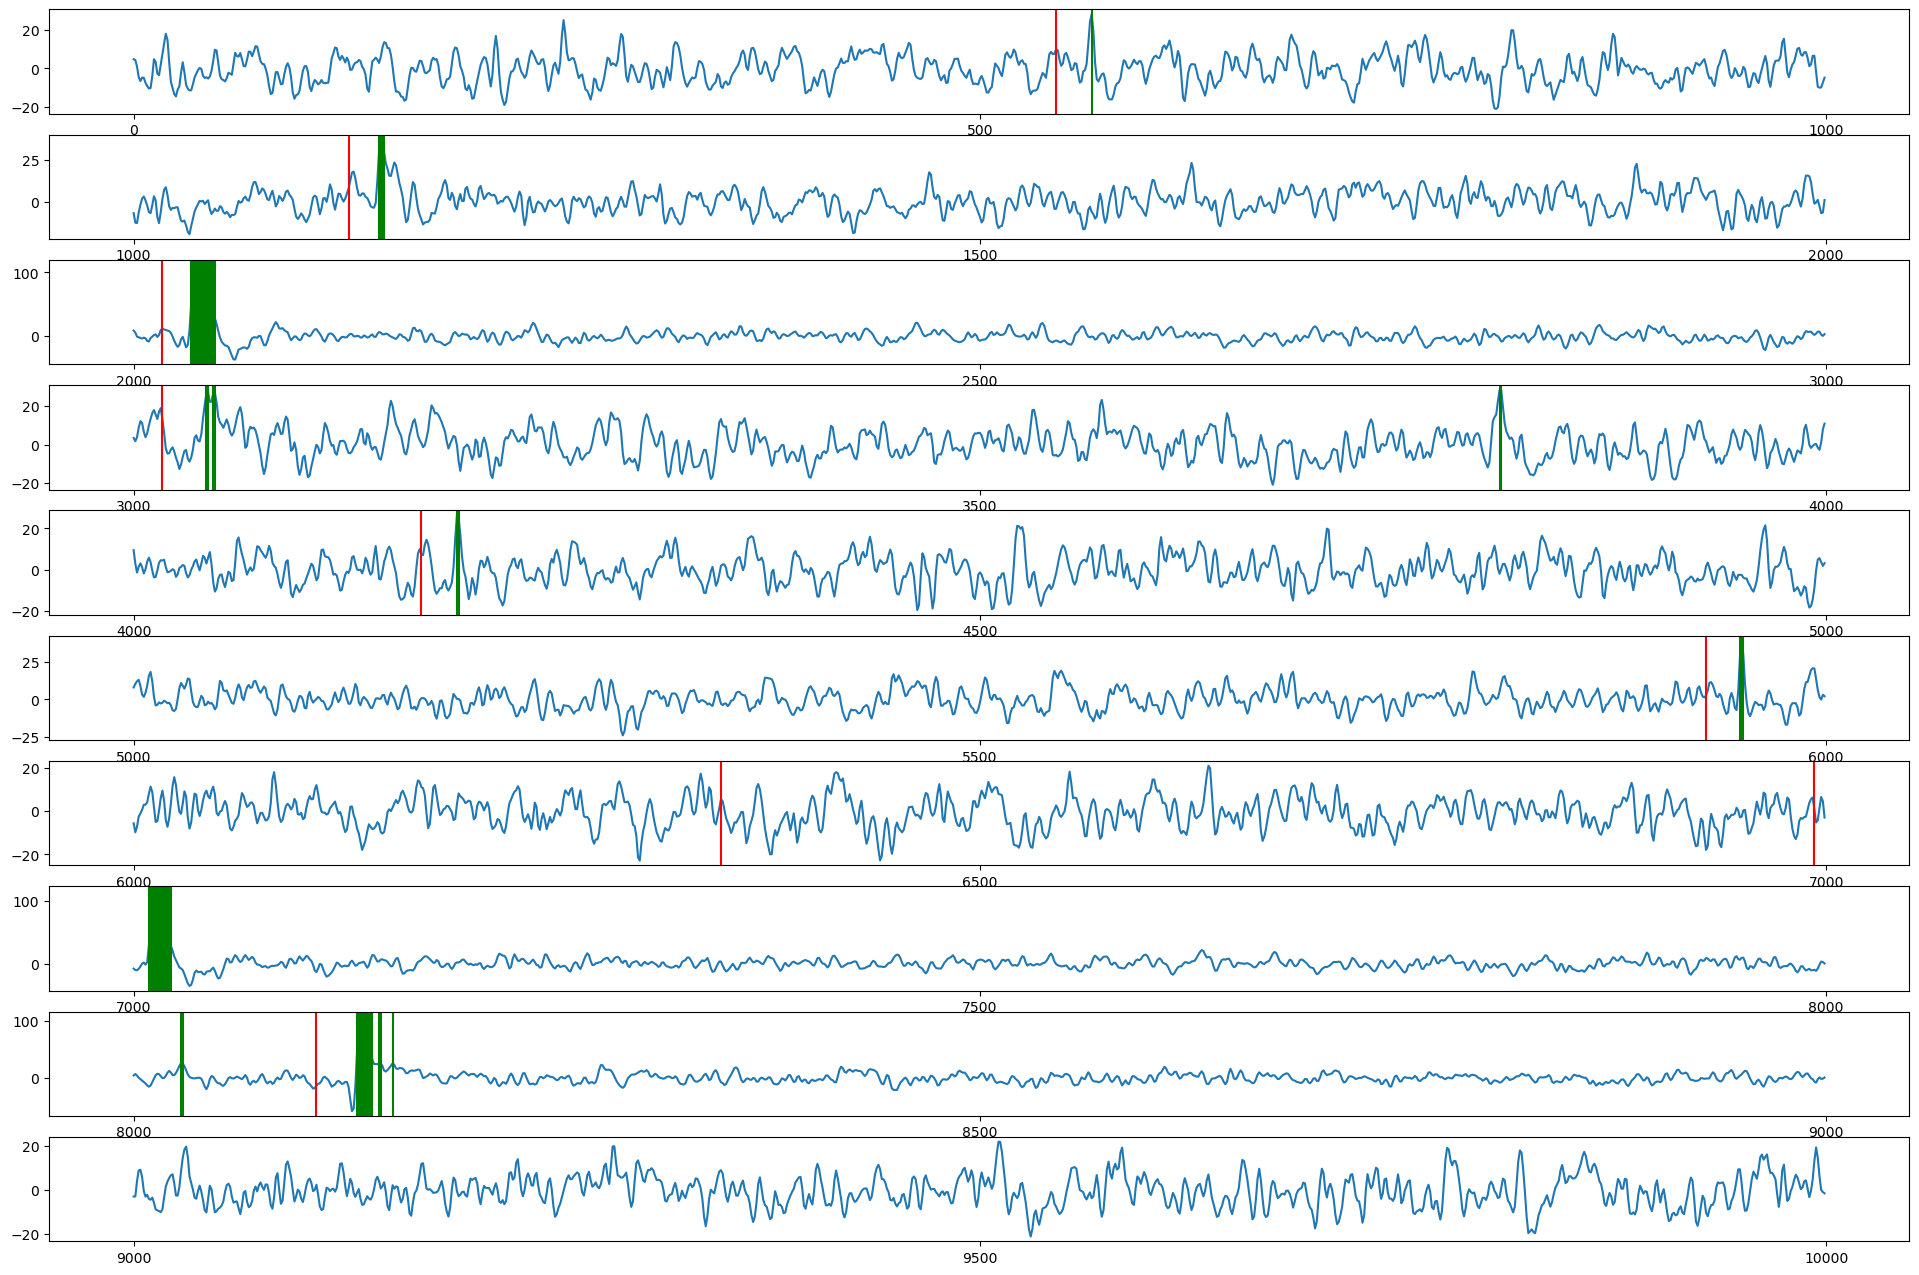

In [22]:
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE
    
    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    # TODO: Clean up, first solution should work but doesnt. Need to get rid of the loops
    # ax[i].axvline(spike_times[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='red', label="ground truth")    
    # ax[i].axvline(detected_spikes[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='green', label="detected")
    
    
    for j, detected in enumerate(detected_spikes):
        if start < detected <= end:
            ax[i].axvline(detected-start, color='green', label="detected")
                
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
            
plt.show() 

We can again observe the offset between the true spike times and the local maxima. Our code detects the maxima. 

We can also see that there are some false positive detections in the first 10000 data points. 

Next steps are to use the Z-score for a more accurate comparison and finetune the threshhold. 

## With Z-Score

In [ ]:
data = mat_file['data'][0]

threshold = mean + 1 * std_dev

detected_spikes = []

for i in range(data.shape[0]-1):
    zscore_i = (data[i] - mean) / std_dev
    zscore_iplus1 = (data[i + 1] + mean) / std_dev
    if zscore_i < threshold and zscore_iplus1 >= threshold:
        detected_spikes.append(i)

In [ ]:
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE
    
    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    # TODO: Clean up, first solution should work but doesnt. Need to get rid of the loops
    # ax[i].axvline(spike_times[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='red', label="ground truth")    
    # ax[i].axvline(detected_spikes[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='green', label="detected")
    
    
    for j, detected in enumerate(detected_spikes):
        if start < detected <= end:
            ax[i].axvline(detected-start, color='green', label="detected")
                
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
            
plt.show() 

Local Outlier Factor Method: Without Thresholding

In [2]:
#### Local Outlier Factors ####



def flatten(arr,variable): #Flatten the data
    data = arr[variable]
    data= data.flatten()
    return data

eeg_signal_total = flatten(mat_file,'data')
eeg_signal_total = (eeg_signal_total)

scaler = StandardScaler()
def Merge_detections(data ,detect_start, detect_stop, window_size):
    j=1
    #spike_indices_merged = []
    outlier_scores_merged = np.array([])
    step_count = (detect_stop-detect_start)//window_size
    while j <= step_count:
        start_time = time.time()
        temp_data = data[detect_start+(j-1)*window_size:detect_start+(j)*window_size]
        data_points = temp_data.reshape(-1, 1)
        lof = LocalOutlierFactor(n_neighbors=140)  # standard value for window_size 10000 is 45
        temp_outlier_scores = lof.fit_predict(data_points)
        for i in range(len(temp_outlier_scores)):
            if temp_outlier_scores[i] == -1:  # Check if current point is an outlier
        # Find the index of the max value in the next 40 points of the signal
                if i + 40 < len(temp_data):
                    temp_outlier = np.argmax(temp_data[i:i+40]) + i  # Find the index relative to the full signal
                    
                    # Set the next 40 points in 'outliers' to 0 (reset outlier flag)
                    for k in range(40):
                        if i + k < len(temp_outlier_scores):  # Ensure we don't go out of bounds
                            temp_outlier_scores[i+k] = 0
                temp_outlier_scores[temp_outlier] =-1
        outlier_scores_merged = np.concatenate((outlier_scores_merged,temp_outlier_scores))
        #print(f"Calculating Local Outlier Factors: {j} of {step_count} in {time.time()-start_time} seconds")
        start_time= time.time()
        j+=1 
    return outlier_scores_merged


Local Outlier Factor - Call the Function

In [3]:
low_bound = 0
up_bound = len(eeg_signal_total)
window_size = 848#10000    ### 848 windowsize retrieved by maximizing tp (n_neighbours = 140) and z_score threshold of 3.0###
#eeg_signal = Create_spikeArray(eeg_signal_total,low_bound,up_bound-low_bound,1000)
#eeg_signal = scaler.fit_transform(eeg_signal.reshape(-1, 1)).flatten()
#data_points = eeg_signal.reshape(-1, 1)

outlier_scores_merged = Merge_detections(eeg_signal_total, low_bound, up_bound,window_size)
spike_indices = np.where(outlier_scores_merged==-1)[0]


Define and Call the Function to print  False Positives, False Negatives, True Positives

In [4]:
def count_fn_fp(ground_truth, predictions, tolerance=40):

    matched_spikes = set()
    true_positive_spikes = set()
    
    update_interval = 1000
    start_time = time.time()

    for idx, d in enumerate(ground_truth):
        found_match = False
        for p in predictions:
            if d - tolerance/5 <= p <= d + 4*tolerance/5:
              
                matched_spikes.add(d)
                true_positive_spikes.add(p)
                found_match = True
                break  

        
        if idx % update_interval == 0:
            print(f"Checking accuracy: {idx // update_interval} of {len(ground_truth) // update_interval} in {time.time() - start_time} seconds")
            start_time = time.time()

    
    false_negative = len(ground_truth) - len(matched_spikes)
    false_positive = len(predictions) - len(true_positive_spikes)
    true_positive = len(true_positive_spikes)
    
    print(f"False Negatives: {false_negative}, False Positives: {false_positive}, True Positives: {true_positive}")
    
    return false_negative, false_positive, true_positive

fn, fp, tp = count_fn_fp(mat_file['spike_times'][0][0][0], spike_indices, tolerance=50)


Checking accuracy: 0 of 3 in 0.00010538101196289062 seconds
Checking accuracy: 1 of 3 in 7.963561773300171 seconds
Checking accuracy: 2 of 3 in 18.192991733551025 seconds
Checking accuracy: 3 of 3 in 30.404452800750732 seconds
False Negatives: 91, False Positives: 35742, True Positives: 3123


Define Thresholder Function and it's Necessities

In [5]:
mean = float(np.mean(eeg_signal_total))
std_dev = float(np.std(eeg_signal_total))

def calculate_zScore(x,mean, std_dev):

    z_score = float((x-mean)/std_dev)
    return z_score

def Check_Spikes(a, threshold): # Sets 0 if under the threshold 
    temp_zScore = calculate_zScore(a,mean, std_dev)
    if abs(temp_zScore) >= threshold:
        return a
    elif temp_zScore < threshold:
        return 0

def Create_spikeArray(dataset, interval_start, interval_length, update_interval):
    temp_array = []
    start_time = time.time() #Measure the Performance
    for i in range(len(dataset[interval_start:interval_length+interval_start])):         
        temp_array.append(Check_Spikes(dataset[i+interval_start], 2.0))
    
        if i%update_interval == 0:
            print(f"Creating Spike Array : {int(i/update_interval)} of {int(len(dataset[interval_start:interval_length+interval_start])/update_interval)} in {time.time()-start_time} seconds")
            start_time = time.time() # Measure the Performance

    data_array = np.array(temp_array).reshape(1, -1)
    data_array = data_array.flatten()
    return data_array

Calling the Same Local Outlier Function with Thresholding (3 standard deviations)

In [6]:
low_bound = 0
up_bound = len(eeg_signal_total)
window_size = 848#10000    ### 848 windowsize retrieved by maximizing tp (n_neighbours = 140) and z_score threshold of 3.0###
eeg_signal = Create_spikeArray(eeg_signal_total,low_bound,up_bound-low_bound,1000)
eeg_signal = scaler.fit_transform(eeg_signal.reshape(-1, 1)).flatten()
data_points = eeg_signal.reshape(-1, 1)

outlier_scores_merged = Merge_detections(eeg_signal, low_bound, up_bound,window_size)
spike_indices = np.where(outlier_scores_merged==-1)[0]

Creating Spike Array : 0 of 2880 in 1.7881393432617188e-05 seconds
Creating Spike Array : 1 of 2880 in 0.00033473968505859375 seconds
Creating Spike Array : 2 of 2880 in 0.00031185150146484375 seconds
Creating Spike Array : 3 of 2880 in 0.00031304359436035156 seconds
Creating Spike Array : 4 of 2880 in 0.00030517578125 seconds
Creating Spike Array : 5 of 2880 in 0.0003046989440917969 seconds
Creating Spike Array : 6 of 2880 in 0.0004134178161621094 seconds
Creating Spike Array : 7 of 2880 in 0.0004551410675048828 seconds
Creating Spike Array : 8 of 2880 in 0.00030875205993652344 seconds
Creating Spike Array : 9 of 2880 in 0.0003123283386230469 seconds
Creating Spike Array : 10 of 2880 in 0.0003066062927246094 seconds
Creating Spike Array : 11 of 2880 in 0.0003108978271484375 seconds
Creating Spike Array : 12 of 2880 in 0.0006055831909179688 seconds
Creating Spike Array : 13 of 2880 in 0.000347137451171875 seconds
Creating Spike Array : 14 of 2880 in 0.00034046173095703125 seconds
Creat

Printing the False Negatives,  False Positives, and True Positives Again

In [7]:
fn, fp, tp = count_fn_fp(mat_file['spike_times'][0][0][0], spike_indices, tolerance=50)

Checking accuracy: 0 of 3 in 5.5789947509765625e-05 seconds
Checking accuracy: 1 of 3 in 4.764723300933838 seconds
Checking accuracy: 2 of 3 in 8.656988143920898 seconds
Checking accuracy: 3 of 3 in 12.982586145401001 seconds
False Negatives: 229, False Positives: 13514, True Positives: 2985


If that catched your attention, the "Window Size" and "n_neighbors" parameters are assigned to somewhat specific values. That is because we use the "Optuna" optimization library to maximize the "True Positive" count.  But as you can see from the raw result, this increases the number of False Positives drastically: "False Negatives: 91, False Positives: 35742, True Positives: 3123" THat is where thresholding comes into play, it eliminates a great proportion of False Positives with an acceptible compromise from True Positives: "False Negatives: 913, False Positives: 934, True Positives: 2301"

In [8]:
default_window_size = 10000
default_n_neighbors = 20

def Merge_detections_tuning(data ,detect_start, detect_stop, window_size, n_neighbors):
    j=1
    #spike_indices_merged = []
    outlier_scores_merged = np.array([])
    step_count = (detect_stop-detect_start)//window_size
    while j <= step_count:
        start_time = time.time()
        temp_data = data[detect_start+(j-1)*window_size:detect_start+(j)*window_size]
        data_points = temp_data.reshape(-1, 1)
        lof = LocalOutlierFactor(n_neighbors)
        temp_outlier_scores = lof.fit_predict(data_points)
        for i in range(len(temp_outlier_scores)):
            if temp_outlier_scores[i] == -1:  # Check if current point is an outlier
        # Find the index of the max value in the next 40 points of the signal
                if i + 40 < len(temp_data):
                    temp_outlier = np.argmax(temp_data[i:i+40]) + i  # Find the index relative to the full signal
                    
                    # Set the next 40 points in 'outliers' to 0 (reset outlier flag)
                    for k in range(40):
                        if i + k < len(temp_outlier_scores):  # Ensure we don't go out of bounds
                            temp_outlier_scores[i+k] = 0
                temp_outlier_scores[temp_outlier] =-1
        outlier_scores_merged = np.concatenate((outlier_scores_merged,temp_outlier_scores))
        print(f"Calculating Local Outlier Factors: {j} of {step_count} in {time.time()-start_time} seconds")
        start_time= time.time()
        j+=1 
    return outlier_scores_merged

def objective(trial):
    # Attempt to suggest values for hyperparameters, fallback to defaults
    window_size = trial.suggest_int('window_size', 10, 100000) if trial else default_window_size
    n_neighbors = trial.suggest_int('n_neighbors', 5, 200) if trial else default_n_neighbors
    #z_score_threshold = trial.suggest_float('z_scores', 0.0, 5.0) if trial else default_z_score_threshold
    eeg_signal = Create_spikeArray(eeg_signal_total,low_bound,up_bound-low_bound,1000)
    
    outlier_scores_merged = Merge_detections_tuning(eeg_signal, low_bound, up_bound,window_size = window_size, n_neighbors=n_neighbors)
    #lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=False)
    spike_indices = np.where(outlier_scores_merged==-1)[0]
    # Fit and predict
    #outliers = lof.fit_predict(eeg_signal_total_scaled)  # Outliers are marked as -1
    
    # Custom scoring: Ratio of outliers detected (adjust as necessary for dataset)
    #outlier_score = np.mean(outliers == -1)  # For example, mean number of outliers detected
    
    fn, fp, tp = count_fn_fp(mat_file['spike_times'][0][0][0], spike_indices, tolerance=50)
    tp
    return (tp) # Return a value to maximize or minimize



study = optuna.create_study(direction='maximize')  # Maximize outlier detection
study.optimize(objective, n_trials=10)  

print("Best Parameters:", study.best_params)
print("Best Outlier Detection Score:", study.best_value)

[I 2024-10-29 12:36:53,278] A new study created in memory with name: no-name-9501e09c-ba7f-45f8-9c59-5e66f9d59498


Creating Spike Array : 0 of 2880 in 8.344650268554688e-06 seconds
Creating Spike Array : 1 of 2880 in 0.0003135204315185547 seconds
Creating Spike Array : 2 of 2880 in 0.00032138824462890625 seconds
Creating Spike Array : 3 of 2880 in 0.00030159950256347656 seconds
Creating Spike Array : 4 of 2880 in 0.00031685829162597656 seconds
Creating Spike Array : 5 of 2880 in 0.00036644935607910156 seconds
Creating Spike Array : 6 of 2880 in 0.0003097057342529297 seconds
Creating Spike Array : 7 of 2880 in 0.00033926963806152344 seconds
Creating Spike Array : 8 of 2880 in 0.00039267539978027344 seconds
Creating Spike Array : 9 of 2880 in 0.0003333091735839844 seconds
Creating Spike Array : 10 of 2880 in 0.0003426074981689453 seconds
Creating Spike Array : 11 of 2880 in 0.00033545494079589844 seconds
Creating Spike Array : 12 of 2880 in 0.0003483295440673828 seconds
Creating Spike Array : 13 of 2880 in 0.0003407001495361328 seconds
Creating Spike Array : 14 of 2880 in 0.00035762786865234375 secon

[I 2024-10-29 12:37:56,606] Trial 0 finished with value: 2985.0 and parameters: {'window_size': 579, 'n_neighbors': 123}. Best is trial 0 with value: 2985.0.


False Negatives: 229, False Positives: 15111, True Positives: 2985
Creating Spike Array : 0 of 2880 in 6.9141387939453125e-06 seconds
Creating Spike Array : 1 of 2880 in 0.00031065940856933594 seconds
Creating Spike Array : 2 of 2880 in 0.00031495094299316406 seconds
Creating Spike Array : 3 of 2880 in 0.00030422210693359375 seconds
Creating Spike Array : 4 of 2880 in 0.0003037452697753906 seconds
Creating Spike Array : 5 of 2880 in 0.0003046989440917969 seconds
Creating Spike Array : 6 of 2880 in 0.0003070831298828125 seconds
Creating Spike Array : 7 of 2880 in 0.0003044605255126953 seconds
Creating Spike Array : 8 of 2880 in 0.0003044605255126953 seconds
Creating Spike Array : 9 of 2880 in 0.0003211498260498047 seconds
Creating Spike Array : 10 of 2880 in 0.0003032684326171875 seconds
Creating Spike Array : 11 of 2880 in 0.00030422210693359375 seconds
Creating Spike Array : 12 of 2880 in 0.0003082752227783203 seconds
Creating Spike Array : 13 of 2880 in 0.000308990478515625 seconds
C

[I 2024-10-29 12:41:04,662] Trial 1 finished with value: 2894.0 and parameters: {'window_size': 12044, 'n_neighbors': 196}. Best is trial 0 with value: 2985.0.


False Negatives: 320, False Positives: 11868, True Positives: 2894
Creating Spike Array : 0 of 2880 in 1.0013580322265625e-05 seconds
Creating Spike Array : 1 of 2880 in 0.0003197193145751953 seconds
Creating Spike Array : 2 of 2880 in 0.000316619873046875 seconds
Creating Spike Array : 3 of 2880 in 0.0003275871276855469 seconds
Creating Spike Array : 4 of 2880 in 0.0003116130828857422 seconds
Creating Spike Array : 5 of 2880 in 0.00031065940856933594 seconds
Creating Spike Array : 6 of 2880 in 0.00031566619873046875 seconds
Creating Spike Array : 7 of 2880 in 0.00031304359436035156 seconds
Creating Spike Array : 8 of 2880 in 0.00031447410583496094 seconds
Creating Spike Array : 9 of 2880 in 0.0003139972686767578 seconds
Creating Spike Array : 10 of 2880 in 0.00031638145446777344 seconds
Creating Spike Array : 11 of 2880 in 0.00031447410583496094 seconds
Creating Spike Array : 12 of 2880 in 0.00031304359436035156 seconds
Creating Spike Array : 13 of 2880 in 0.00031757354736328125 secon

[I 2024-10-29 12:49:26,614] Trial 2 finished with value: 545.0 and parameters: {'window_size': 52937, 'n_neighbors': 53}. Best is trial 0 with value: 2985.0.


Checking accuracy: 3 of 3 in 0.8887536525726318 seconds
False Negatives: 2669, False Positives: 234, True Positives: 545
Creating Spike Array : 0 of 2880 in 7.152557373046875e-06 seconds
Creating Spike Array : 1 of 2880 in 0.0003554821014404297 seconds
Creating Spike Array : 2 of 2880 in 0.0003097057342529297 seconds
Creating Spike Array : 3 of 2880 in 0.0003223419189453125 seconds
Creating Spike Array : 4 of 2880 in 0.0003094673156738281 seconds
Creating Spike Array : 5 of 2880 in 0.00031256675720214844 seconds
Creating Spike Array : 6 of 2880 in 0.0003237724304199219 seconds
Creating Spike Array : 7 of 2880 in 0.0003120899200439453 seconds
Creating Spike Array : 8 of 2880 in 0.0003123283386230469 seconds
Creating Spike Array : 9 of 2880 in 0.00032973289489746094 seconds
Creating Spike Array : 10 of 2880 in 0.00031256675720214844 seconds
Creating Spike Array : 11 of 2880 in 0.00031280517578125 seconds
Creating Spike Array : 12 of 2880 in 0.00032639503479003906 seconds
Creating Spike A

[I 2024-10-29 13:03:00,607] Trial 3 finished with value: 708.0 and parameters: {'window_size': 78368, 'n_neighbors': 187}. Best is trial 0 with value: 2985.0.


False Negatives: 2506, False Positives: 694, True Positives: 708
Creating Spike Array : 0 of 2880 in 6.4373016357421875e-06 seconds
Creating Spike Array : 1 of 2880 in 0.0003097057342529297 seconds
Creating Spike Array : 2 of 2880 in 0.00030994415283203125 seconds
Creating Spike Array : 3 of 2880 in 0.0003039836883544922 seconds
Creating Spike Array : 4 of 2880 in 0.0002989768981933594 seconds
Creating Spike Array : 5 of 2880 in 0.000301361083984375 seconds
Creating Spike Array : 6 of 2880 in 0.00029778480529785156 seconds
Creating Spike Array : 7 of 2880 in 0.0003025531768798828 seconds
Creating Spike Array : 8 of 2880 in 0.0003190040588378906 seconds
Creating Spike Array : 9 of 2880 in 0.0003032684326171875 seconds
Creating Spike Array : 10 of 2880 in 0.000301361083984375 seconds
Creating Spike Array : 11 of 2880 in 0.0003027915954589844 seconds
Creating Spike Array : 12 of 2880 in 0.0003120899200439453 seconds
Creating Spike Array : 13 of 2880 in 0.00030541419982910156 seconds
Creat

[I 2024-10-29 13:06:28,774] Trial 4 finished with value: 676.0 and parameters: {'window_size': 20089, 'n_neighbors': 29}. Best is trial 0 with value: 2985.0.


False Negatives: 2538, False Positives: 479, True Positives: 676
Creating Spike Array : 0 of 2880 in 7.3909759521484375e-06 seconds
Creating Spike Array : 1 of 2880 in 0.00031447410583496094 seconds
Creating Spike Array : 2 of 2880 in 0.00030732154846191406 seconds
Creating Spike Array : 3 of 2880 in 0.00030684471130371094 seconds
Creating Spike Array : 4 of 2880 in 0.0003020763397216797 seconds
Creating Spike Array : 5 of 2880 in 0.00030803680419921875 seconds
Creating Spike Array : 6 of 2880 in 0.0003046989440917969 seconds
Creating Spike Array : 7 of 2880 in 0.0003097057342529297 seconds
Creating Spike Array : 8 of 2880 in 0.000316619873046875 seconds
Creating Spike Array : 9 of 2880 in 0.00031185150146484375 seconds
Creating Spike Array : 10 of 2880 in 0.0003104209899902344 seconds
Creating Spike Array : 11 of 2880 in 0.0003151893615722656 seconds
Creating Spike Array : 12 of 2880 in 0.00031185150146484375 seconds
Creating Spike Array : 13 of 2880 in 0.00031685829162597656 seconds


[I 2024-10-29 13:10:57,891] Trial 5 finished with value: 596.0 and parameters: {'window_size': 27823, 'n_neighbors': 35}. Best is trial 0 with value: 2985.0.


Creating Spike Array : 0 of 2880 in 7.867813110351562e-06 seconds
Creating Spike Array : 1 of 2880 in 0.0005021095275878906 seconds
Creating Spike Array : 2 of 2880 in 0.0004935264587402344 seconds
Creating Spike Array : 3 of 2880 in 0.0003311634063720703 seconds
Creating Spike Array : 4 of 2880 in 0.0003192424774169922 seconds
Creating Spike Array : 5 of 2880 in 0.0003218650817871094 seconds
Creating Spike Array : 6 of 2880 in 0.0003333091735839844 seconds
Creating Spike Array : 7 of 2880 in 0.00032448768615722656 seconds
Creating Spike Array : 8 of 2880 in 0.0003216266632080078 seconds
Creating Spike Array : 9 of 2880 in 0.00033593177795410156 seconds
Creating Spike Array : 10 of 2880 in 0.00040721893310546875 seconds
Creating Spike Array : 11 of 2880 in 0.0005671977996826172 seconds
Creating Spike Array : 12 of 2880 in 0.0005314350128173828 seconds
Creating Spike Array : 13 of 2880 in 0.0005600452423095703 seconds
Creating Spike Array : 14 of 2880 in 0.0011050701141357422 seconds
Cr

[I 2024-10-29 13:17:26,924] Trial 6 finished with value: 1559.0 and parameters: {'window_size': 33365, 'n_neighbors': 153}. Best is trial 0 with value: 2985.0.


False Negatives: 1655, False Positives: 451, True Positives: 1559
Creating Spike Array : 0 of 2880 in 6.67572021484375e-06 seconds
Creating Spike Array : 1 of 2880 in 0.0003077983856201172 seconds
Creating Spike Array : 2 of 2880 in 0.0003077983856201172 seconds
Creating Spike Array : 3 of 2880 in 0.0003063678741455078 seconds
Creating Spike Array : 4 of 2880 in 0.0003027915954589844 seconds
Creating Spike Array : 5 of 2880 in 0.0003070831298828125 seconds
Creating Spike Array : 6 of 2880 in 0.00030350685119628906 seconds
Creating Spike Array : 7 of 2880 in 0.0003020763397216797 seconds
Creating Spike Array : 8 of 2880 in 0.00030612945556640625 seconds
Creating Spike Array : 9 of 2880 in 0.0003044605255126953 seconds
Creating Spike Array : 10 of 2880 in 0.00030422210693359375 seconds
Creating Spike Array : 11 of 2880 in 0.00030493736267089844 seconds
Creating Spike Array : 12 of 2880 in 0.0003108978271484375 seconds
Creating Spike Array : 13 of 2880 in 0.0003066062927246094 seconds
Cre

[I 2024-10-29 13:33:26,033] Trial 7 finished with value: 616.0 and parameters: {'window_size': 94959, 'n_neighbors': 188}. Best is trial 0 with value: 2985.0.


False Negatives: 2598, False Positives: 603, True Positives: 616
Creating Spike Array : 0 of 2880 in 7.867813110351562e-06 seconds
Creating Spike Array : 1 of 2880 in 0.00032210350036621094 seconds
Creating Spike Array : 2 of 2880 in 0.00031566619873046875 seconds
Creating Spike Array : 3 of 2880 in 0.0003094673156738281 seconds
Creating Spike Array : 4 of 2880 in 0.0003132820129394531 seconds
Creating Spike Array : 5 of 2880 in 0.0003159046173095703 seconds
Creating Spike Array : 6 of 2880 in 0.000316619873046875 seconds
Creating Spike Array : 7 of 2880 in 0.00032019615173339844 seconds
Creating Spike Array : 8 of 2880 in 0.0003197193145751953 seconds
Creating Spike Array : 9 of 2880 in 0.00032591819763183594 seconds
Creating Spike Array : 10 of 2880 in 0.0003273487091064453 seconds
Creating Spike Array : 11 of 2880 in 0.0003230571746826172 seconds
Creating Spike Array : 12 of 2880 in 0.000324249267578125 seconds
Creating Spike Array : 13 of 2880 in 0.0003228187561035156 seconds
Creat

[I 2024-10-29 13:36:20,124] Trial 8 finished with value: 2238.0 and parameters: {'window_size': 12256, 'n_neighbors': 142}. Best is trial 0 with value: 2985.0.


False Negatives: 976, False Positives: 9103, True Positives: 2238
Creating Spike Array : 0 of 2880 in 7.62939453125e-06 seconds
Creating Spike Array : 1 of 2880 in 0.00032782554626464844 seconds
Creating Spike Array : 2 of 2880 in 0.0003635883331298828 seconds
Creating Spike Array : 3 of 2880 in 0.0004482269287109375 seconds
Creating Spike Array : 4 of 2880 in 0.0003135204315185547 seconds
Creating Spike Array : 5 of 2880 in 0.0003094673156738281 seconds
Creating Spike Array : 6 of 2880 in 0.00030875205993652344 seconds
Creating Spike Array : 7 of 2880 in 0.0003275871276855469 seconds
Creating Spike Array : 8 of 2880 in 0.00031304359436035156 seconds
Creating Spike Array : 9 of 2880 in 0.00031113624572753906 seconds
Creating Spike Array : 10 of 2880 in 0.0003199577331542969 seconds
Creating Spike Array : 11 of 2880 in 0.0003070831298828125 seconds
Creating Spike Array : 12 of 2880 in 0.0003190040588378906 seconds
Creating Spike Array : 13 of 2880 in 0.00031280517578125 seconds
Creating

[I 2024-10-29 13:42:23,148] Trial 9 finished with value: 1239.0 and parameters: {'window_size': 32328, 'n_neighbors': 117}. Best is trial 0 with value: 2985.0.


False Negatives: 1975, False Positives: 687, True Positives: 1239
Best Parameters: {'window_size': 579, 'n_neighbors': 123}
Best Outlier Detection Score: 2985.0


## Without Z-Score and Average over a Several Points

In [ ]:
# TODO

# Trainable Parameters

- Threshold
- Group Average

## Threshold
If we set the threshold higher we will increase the number of false negative predictions. In other words, we will 

## Sliding Window (Average of group of points)


TODO

Features:


# Principal Component Analysis

